### Read from HDF5 files

In [1]:
%matplotlib notebook
import sys, os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from cookiebox_forYoussef.src.h5todatasets import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, utils
import glob

FPATH = '/home/ynashed/workspace/data/cookiebox/*.h5'
data_files = glob.glob(FPATH)
X = []
Y = []
for fname in data_files:
    f = h5py.File(fname,'r')
    imkeys = [i for i in list(f.keys()) if re.match('^img\d+',i)]
    for imkey in imkeys:
        carrier = f[imkey].attrs['carrier']
        h = f[imkey]['hist'][()]
        phases = [phase2id(carrier + f[imkey].attrs['ephases'][i]) for i in range(f[imkey].attrs['npulses'])]
        X.append(h)
        Y.append(phases)
    f.close()
X = np.array(X)
targets = np.array([len(y) for y in Y])[...,np.newaxis]
y = OneHotEncoder(sparse=False).fit_transform(targets)
print(X.shape, y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_normalized = utils.normalize(X_train, axis=1).astype(np.float32)
X_test_normalized = utils.normalize(X_test, axis=1).astype(np.float32)

/home/ynashed/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(10000, 2048, 16) (10000, 3)


### Visualize an example

float32


<IPython.core.display.Javascript object>


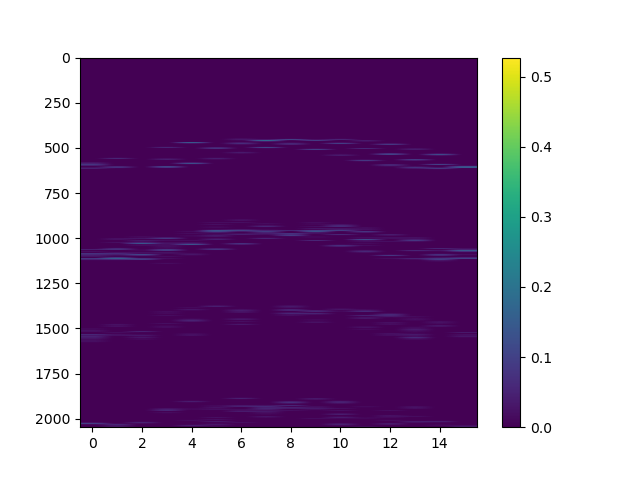

[0. 0. 1.]


In [2]:
dindex = np.random.choice(np.arange(X_train_normalized.shape[0]))
data = X_train_normalized[dindex]

print(data.dtype)

fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(data)
ax.set_aspect('auto')
fig.colorbar(img, ax=ax)

print(y_train[dindex])

### Let's try a baseline bi-directional LSTM model

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2048, 16)]        0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 2048, 64)          20992     
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 64)                33280     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 54,467
Trainable params: 54,467
Non-trainable params: 0
_________________________________________________________________
Train on 7200 samples, validate on 800 samples
Epoch 1/50
7200/7200 [==============================] - 20s 3ms/sample - loss: 1.0769 - acc: 0.4215 - val_loss: 1.4919 - val_acc: 0.3288
Epoch 2/50
7200/7200 [==============================] - 20s 3ms/sampl

<IPython.core.display.Javascript object>


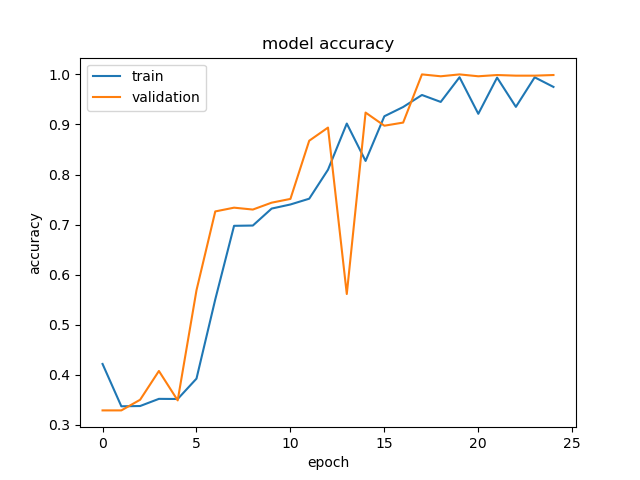

<IPython.core.display.Javascript object>


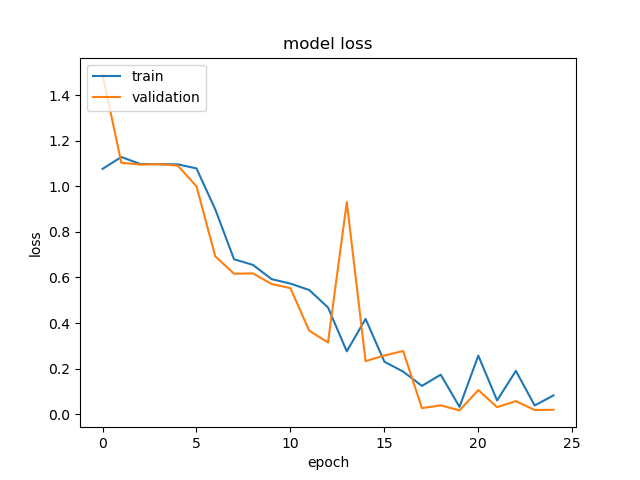

In [8]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Bidirectional, Dense, CuDNNLSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

nclasses = y_train.shape[1]
nenergies = X_train_normalized.shape[1]
nangles = X_train_normalized.shape[2]
nvocab = X_train_normalized.max()

# Input for variable-length sequences of integers
inputs = Input(shape=(nenergies, nangles))
x = inputs
# Embed each integer in a 3-dimensional vector
# x = layers.Embedding(nvocab, 3, input_length=nenergies)(x)
# Add 2 bidirectional LSTMs
x = (CuDNNLSTM(64, return_sequences=True))(x)
x = (CuDNNLSTM(64))(x)
# Add a classifier
outputs = Dense(nclasses, activation="softmax")(x)
model = Model(inputs, outputs)
model.summary()

my_callbacks = [EarlyStopping(monitor='val_loss', min_delta=0,
                              patience=5, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True),
                TensorBoard(log_dir='./logs')]
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train_normalized, y_train, batch_size=64, epochs=50, 
                    callbacks=my_callbacks, validation_split=0.1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

model.save('best_lstm.h5')

### Test the model on unseen data

In [12]:
from tensorflow.keras.models import load_model

model = load_model('best_lstm.h5')
model.evaluate(X_test_normalized, y_test)

2000/2000 [==============================] - 4s 2ms/sample - loss: 0.0198 - acc: 0.9985


[0.019787300407886507, 0.9985]